In [3]:
import torch 
import torch.nn as nn
from math import ceil
import pandas as pd
import cv2
import albumentations as A
import numpy as np
from PIL import Image
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import tqdm.notebook as tq

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Datasets/Image_classification_Dataset.zip'

In [6]:
train = pd.read_csv('/content/train-scene classification/train.csv')
TRAIN_PATH = '/content/train-scene classification/train/'
train.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [7]:
train, val = train_test_split(train, test_size = 0.2, stratify = train.label.values)

5


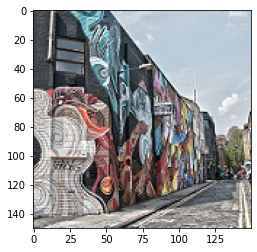

In [8]:
  random = np.random.randint(5040)  
  img_example = Image.open(TRAIN_PATH + train.iloc[random,0])
  print(train.iloc[random,1])
  plt.imshow(img_example)

In [9]:
base_model = [
              # expand ratio, channels, num layers, stride, kernel size
              [1,16 ,1 ,1 ,3],
              [6, 24, 2, 2, 3],
              [6, 40, 2, 2, 5],
              [6, 80, 3, 2, 3],
              [6, 112, 3, 1, 5],
              [6, 192, 4, 2, 5],
              [6, 320, 1, 1, 3]
]


phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}
# (alpha, beta  == constants), depth = alpha ** phi

In [10]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups = 1):
    super(CNNBlock,self).__init__()
    self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,groups=groups,bias= False)
    self.bn = nn.BatchNorm2d(out_channels)
    self.silu = nn.SiLU()
  def forward(self,x):
    return self.silu(self.bn(self.cnn(x)))

class SquezzeExcitation(nn.Module):
  def __init__(self, in_channels, reduced_dim):
    super(SquezzeExcitation,self).__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(in_channels,reduced_dim,1),
        nn.SiLU(),
        nn.Conv2d(reduced_dim,in_channels,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return x * self.se(x)


class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, expand_ratio, reduction=4, survival_prob=0.8 ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )
        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim),
            SquezzeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)





class EfficientNet(nn.Module):
  def __init__(self,version, num_classes):
    super(EfficientNet, self).__init__()
    width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
    last_channels = ceil(1280 * width_factor)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.features = self.create_features(width_factor, depth_factor, last_channels)
    self.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(last_channels,num_classes),

    )
  
  def calculate_factors(self, version, alpha = 1.2, beta = 1.1):
    phi, res, drop_rate = phi_values[version]
    depth_factor = alpha ** phi
    width_factor = beta ** phi
    return depth_factor, width_factor, drop_rate
  def create_features(self, width_factor, depth_factor, last_channels):
    channels = int(32 * width_factor)
    features = [CNNBlock(3, channels, 3, stride = 2, padding = 1)]
    in_channels = channels

    for expand_ratio,channels,repeats, stride, kernel_size in base_model:
      out_channels = 4 * ceil(int(channels * width_factor) / 4)
      layers_repeats = ceil(repeats * depth_factor)
      
      for layer in range(layers_repeats):
        features.append(
            InvertedResidualBlock(
                in_channels,
                out_channels,
                expand_ratio = expand_ratio,
                stride = stride if layer == 0 else 1,
                kernel_size = kernel_size,
                padding = kernel_size // 2,
            )
        )
        in_channels = out_channels
    features.append(
        CNNBlock(in_channels, last_channels, kernel_size = 1, stride = 1,padding = 1)
    )
    return nn.Sequential(*features)
  def forward(self,x):
    x = self.pool(self.features(x))
    return self.classifier(x.view(x.shape[0],-1))






In [11]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            res = self.transform(image = image)
            image = res['image']

        return (image, y_label)

In [12]:
torch.cuda.empty_cache()

In [13]:
image_size = 380

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
num_epochs = 5
in_channel = 3
num_classes = 6
learning_rate = 1e-3
version = 'b3'

In [14]:
transforms = train_transform = A.Compose(
        [
            A.Resize(height=image_size, width=image_size),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [15]:
train_dataset = ImageDataset(root_dir= TRAIN_PATH, dataframe = train,
                             transform = transforms)
val_dataset = ImageDataset(root_dir= TRAIN_PATH, dataframe = val,
                             transform = transforms)

In [16]:
train_loader = DataLoader(dataset= train_dataset, batch_size=batch_size, shuffle = True)
val_loader =  DataLoader(dataset= val_dataset, batch_size=batch_size, shuffle = True)

In [17]:
model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [19]:
train_loss_list = []
valid_loss_list = []
lr_rate_list = []
for epoch in range(1,num_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    bar = tq.tqdm(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})

    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq.tqdm(val_loader, postfix={"valid_loss":0.0})
        for data, target in bar:
            data =  data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item()})
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    

    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))


Epoch: 1  Training Loss: 1.298155  Validation Loss: 1.067577



Epoch: 2  Training Loss: 1.005372  Validation Loss: 0.828485



Epoch: 3  Training Loss: 0.845940  Validation Loss: 0.712820



Epoch: 4  Training Loss: 0.754210  Validation Loss: 0.665047



Epoch: 5  Training Loss: 0.689972  Validation Loss: 0.624676


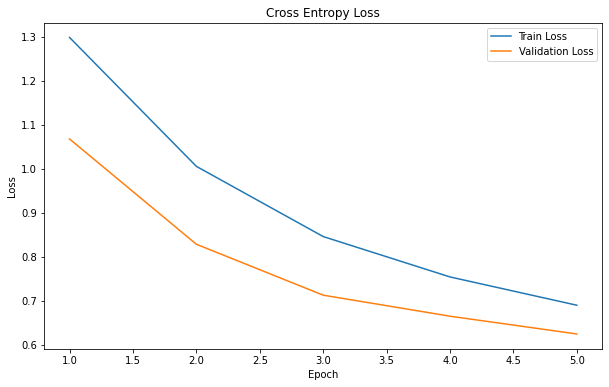

In [21]:
plt.figure(figsize=(10,6))
plt.plot([i for i in range(1,num_epochs+1)], train_loss_list, label = "Train Loss")
plt.plot([i for i in range(1,num_epochs+1)], valid_loss_list, label = "Validation Loss")
plt.title("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()